In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import csv, time    #for logging parameter performances

In [4]:
print(cv2.__version__)
print("legacy check:", hasattr(cv2, "legacy"))
print("KCF:", hasattr(cv2.legacy, "TrackerKCF_create"))

4.12.0
legacy check: True
KCF: True


In [ ]:
VIDEO_SOURCE = "Validation_Video_tracker_mode.mp4"          # 0=USB cam, or "video.mp4"
PROCESS_W, PROCESS_H = 640, 360

YOLO_MODEL_PATH = "best.pt"   
YOLO_IMG_SIZE = 416              
YOLO_CONF = 0.40
DETECT_EVERY_N_FRAMES = 7        
IOU_REINIT_TH = 0.25             # tracker bbox and detection iou treshold
HIST_SIM_TH = 0.50               # drift histogram similarity treshold (0..1)
LOST_TH = 10                     # lost treshold

TRACKER_TYPE = "KCF"            #or you can use CSRT

In [6]:
def create_tracker(tracker_type: str):
    t = tracker_type.upper()
    if t == "KCF":
        return cv2.TrackerKCF_create()
    elif t == "CSRT":
        return cv2.TrackerCSRT_create()
    else:
        raise ValueError("Unsupported tracker. Use KCF or CSRT.")

In [7]:
def xyxy_to_xywh(xyxy):
    x1, y1, x2, y2 = xyxy
    return (float(x1), float(y1), float(x2 - x1), float(y2 - y1))

def xywh_to_xyxy(xywh):
    x, y, w, h = xywh
    return (x, y, x + w, y + h)

In [ ]:
def iou_xywh(a, b):

    ax1, ay1, ax2, ay2 = xywh_to_xyxy(a) 
    bx1, by1, bx2, by2 = xywh_to_xyxy(b)
    
    #intersection
    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)
    
    iw = max(0.0, inter_x2 - inter_x1) #0.0 -> so that there's no negative value if there's no intersection
    ih = max(0.0, inter_y2 - inter_y1)
    inter = iw * ih
    
    area_a = max(0.0, (ax2 - ax1)) * max(0.0, (ay2 - ay1))
    area_b = max(0.0, (bx2 - bx1)) * max(0.0, (by2 - by1))
    
    union = area_a + area_b - inter + 1e-9
    
    return inter / union

In [ ]:
def clamp_bbox_xywh(bbox, W, H):
    x, y, w, h = bbox
    x = max(0, min(x, W - 1))
    y = max(0, min(y, H - 1))
    w = max(1, min(w, W - x))
    h = max(1, min(h, H - y))
    return (x, y, w, h)

In [ ]:
def crop_roi(frame, bbox): 
    x, y, w, h = map(int, bbox)
    return frame[y:y+h, x:x+w]


def hsv_hist_signature(frame, bbox):
    roi = crop_roi(frame, bbox)
    if roi.size == 0:
        return None
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # H + S histogram
    
    hist = cv2.calcHist( 
        [hsv], 
        [0, 1], 
        None, 
        [30, 32], 
        [0, 180, 0, 256]
        )
    
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    return hist

In [ ]:
def hist_similarity(hist_a, hist_b):
    if hist_a is None or hist_b is None:
        return 0.0
    
    sim = cv2.compareHist(hist_a, hist_b, cv2.HISTCMP_CORREL)
    
    sim01 = (sim + 1) / 2
    return float(sim01)

In [ ]:
def run_yolo(model, frame_bgr):
    # Ultralytics needs BGR
    results = model.predict(frame_bgr, imgsz=YOLO_IMG_SIZE, conf=YOLO_CONF, verbose=False)
    r = results[0]
    dets = []
    if r.boxes is None:
        return dets
    for b in r.boxes:
        xyxy = b.xyxy[0].cpu().numpy()
        conf = float(b.conf[0].cpu().numpy())
        cls = int(b.cls[0].cpu().numpy())
        dets.append((xyxy_to_xywh(xyxy), conf, cls))
    return dets

In [ ]:
def select_best_detection(dets, frame_w, frame_h):
    
    #selection: biggest area * confidence
    
    if not dets:
        return None
    best = None
    best_score = -1
    for (bbox, conf, cls) in dets:
        x, y, w, h = bbox
        area = w * h
        score = area * conf
        if score > best_score:
            best_score = score
            best = (bbox, conf, cls)
    if best is None:
        return None
    bbox, conf, cls = best
    bbox = clamp_bbox_xywh(bbox, frame_w, frame_h)
    return bbox, conf, cls

In [14]:
def draw_bbox(frame, bbox, text=None):
    x, y, w, h = map(int, bbox)
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    if text:
        cv2.putText(frame, text, (x, max(0, y-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

In [ ]:
def to_cv_bbox_xywh(bbox, W=None, H=None): #W and H is none by default
    
    b = np.asarray(bbox).reshape(-1)

    if b.size != 4:
        raise ValueError(f"bbox hasn't got 4 items! bbox={bbox}  -> shape={np.asarray(bbox).shape}")

    x, y, w, h = [float(v) for v in b.tolist()]


    if W is not None and H is not None:
        x = max(0.0, min(x, W - 1.0))
        y = max(0.0, min(y, H - 1.0))
        w = max(1.0, min(w, W - x))
        h = max(1.0, min(h, H - y))
    else:
        w = max(1.0, w)
        h = max(1.0, h)


    return (int(round(x)), int(round(y)), int(round(w)), int(round(h)))

In [16]:
def reinit_tracker(tracker_type, frame, bbox_any):
    
    H, W = frame.shape[:2]
    bbox_cv = to_cv_bbox_xywh(bbox_any, W=W, H=H)  # int (x,y,w,h)

    trk = create_tracker(tracker_type)
    trk.init(frame, bbox_cv)
    
    return trk, bbox_cv

In [ ]:
def main():
    import time, csv

    cap = cv2.VideoCapture(VIDEO_SOURCE)
    if not cap.isOpened():
        raise RuntimeError("Video source could not be opened.")

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)

    model = YOLO(YOLO_MODEL_PATH)

    tracker = None
    target_hist = None
    tracking = False
    lost_counter = 0
    frame_id = 0

    # Video saving settings
    SAVE_OUTPUT = True
    OUT_PATH = "tracked_output.mp4"

    OUT_FPS = cap.get(cv2.CAP_PROP_FPS)
    if OUT_FPS is None or OUT_FPS <= 1:
        OUT_FPS = 30

    writer = None
    if SAVE_OUTPUT:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(OUT_PATH, fourcc, OUT_FPS, (PROCESS_W, PROCESS_H))
        if not writer.isOpened():
            raise RuntimeError("VideoWriter couldn't be opened. Check Codec/folder permissions.")

    # CSV log settings
    LOG_PATH = f"metrics_N{DETECT_EVERY_N_FRAMES}.csv"
    logf = open(LOG_PATH, "w", newline="", encoding="utf-8")
    csvw = csv.writer(logf)
    csvw.writerow([
        "N", "frame_id", "mode", "yolo_ran", "refreshed",
        "sim", "iou", "lost_counter", "frame_ms"
    ])

    t_prev = time.perf_counter()

    try:
        while True:
            ok, frame = cap.read()
            if not ok:
                break

            frame = cv2.resize(frame, (PROCESS_W, PROCESS_H))
            H, W = frame.shape[:2]
            frame_id += 1

            # log variables of this frame
            mode = "TRACK"      # default
            yolo_ran = 0
            refreshed = 0
            sim = None
            iou = None

     
            # MODE: Detect
   
            if (not tracking) or (lost_counter > LOST_TH):
                mode = "DETECT"
                yolo_ran = 1

                dets = run_yolo(model, frame)
                sel = select_best_detection(dets, W, H)

                if sel is not None:
                    bbox, conf, cls = sel
                    tracker, bbox_cv = reinit_tracker(TRACKER_TYPE, frame, bbox)
                    target_hist = hsv_hist_signature(frame, bbox_cv)

                    tracking = True
                    lost_counter = 0
                    refreshed = 1  # init
                    draw_bbox(frame, bbox_cv, f"YOLO lock conf={conf:.2f}")
                else:
                    tracking = False
                    lost_counter += 1
                    cv2.putText(frame, "Searching (YOLO)...", (10, 25),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

      
            # MODE: Track
    
            else:
                ok, bbox_t = tracker.update(frame)
                if not ok:
                    lost_counter += 1
                    cv2.putText(frame, f"Tracker lost ({lost_counter})", (10, 25),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                else:
                    bbox_t = clamp_bbox_xywh(bbox_t, W, H)

                    # Drift control (histogram)
                    cur_hist = hsv_hist_signature(frame, bbox_t)
                    sim = hist_similarity(target_hist, cur_hist)

                    # center + error
                    x, y, w, h = bbox_t
                    cx = x + w / 2
                    cy = y + h / 2
                    ex = (cx - W / 2) / (W / 2)
                    ey = (cy - H / 2) / (H / 2)

                    draw_bbox(frame, bbox_t, f"trk sim={sim:.2f} ex={ex:.2f} ey={ey:.2f}")

                    # Drift -> reacquire
                    if sim < HIST_SIM_TH:
                        lost_counter += 2
                        cv2.putText(frame, "Drift suspected -> YOLO reacquire soon", (10, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                    else:
                        lost_counter = max(0, lost_counter - 1)

                    # YOLO refresh
                    if frame_id % DETECT_EVERY_N_FRAMES == 0:
                        yolo_ran = 1
                        dets = run_yolo(model, frame)
                        sel = select_best_detection(dets, W, H)

                        if sel is not None:
                            bbox_y, conf, cls = sel
                            iou = iou_xywh(bbox_t, bbox_y)

                            if iou > IOU_REINIT_TH or lost_counter > 0:
                                tracker, bbox_cv = reinit_tracker(TRACKER_TYPE, frame, bbox_y)
                                target_hist = hsv_hist_signature(frame, bbox_cv)
                                refreshed = 1

                                cv2.putText(frame, f"YOLO refresh iou={iou:.2f} conf={conf:.2f}", (10, 75),
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

            # FPS
            t_now = time.perf_counter()
            frame_ms = (t_now - t_prev) * 1000.0
            t_prev = t_now

            # CSV row
            csvw.writerow([
                DETECT_EVERY_N_FRAMES, frame_id, mode, yolo_ran, refreshed,
                "" if sim is None else f"{sim:.4f}",
                "" if iou is None else f"{iou:.4f}",
                lost_counter, f"{frame_ms:.3f}"
            ])

            # Write Video & Show
            if writer is not None:
                writer.write(frame)

            cv2.imshow("vehicle_track", frame)
            if cv2.waitKey(1) & 0xFF == 27:
                break

    finally:
        cap.release()
        if writer is not None:
            writer.release()
        cv2.destroyAllWindows()
        logf.close()
        print("Saved:", OUT_PATH)
        print("CSV log:", LOG_PATH)


In [18]:
if __name__ == "__main__":
    main()

Kaydedildi: tracked_output.mp4
CSV log: metrics_N10.csv


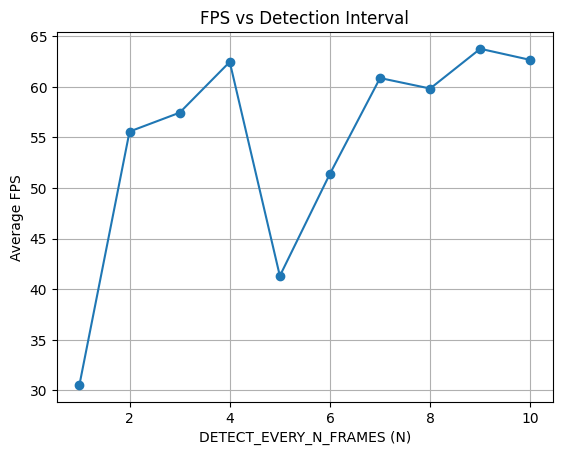

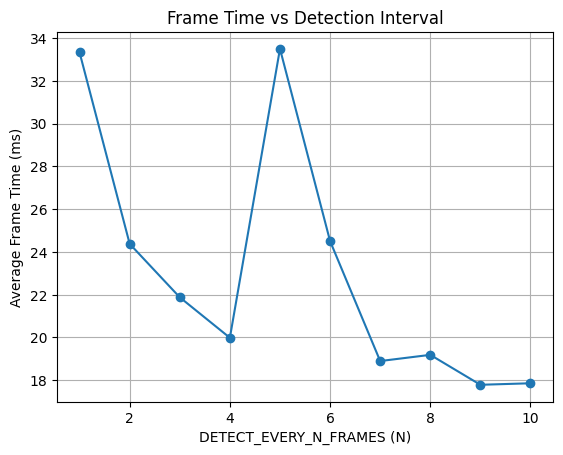

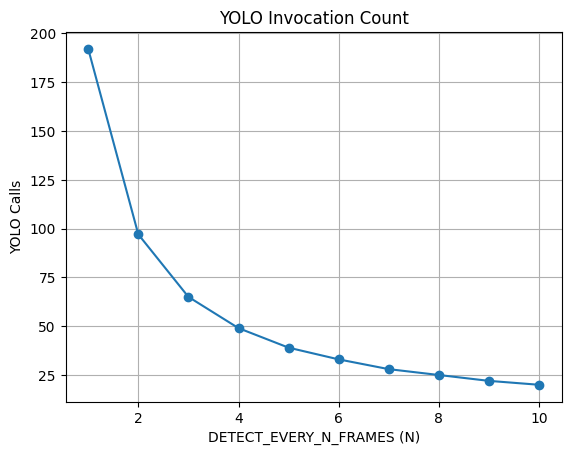

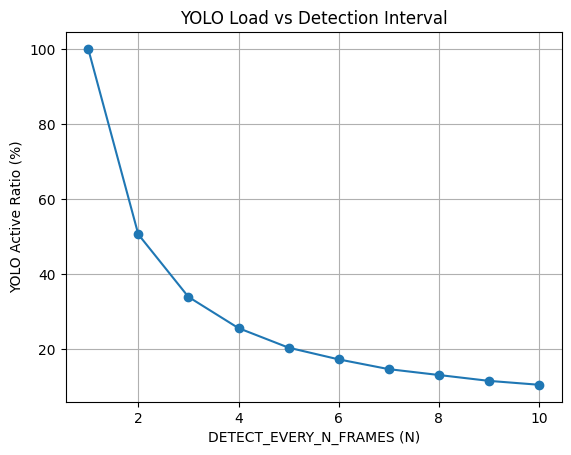

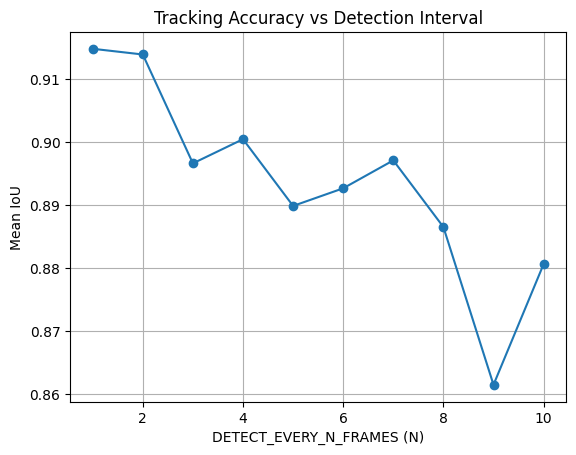

In [ ]:
# Graphs

import pandas as pd
import matplotlib.pyplot as plt


# Load CSV files


files = [f"metrics/metrics_N{i}.csv" for i in range(1, 11)]

summary = []

for f in files:
    df = pd.read_csv(f)

    avg_fps = (1000 / df["frame_ms"]).mean()
    avg_frame_ms = df["frame_ms"].mean()
    yolo_calls = df["yolo_ran"].sum()
    yolo_rate = df["yolo_ran"].mean() * 100
    iou_mean = df["iou"].dropna().mean()

    N = int(df["N"].iloc[0])

    summary.append({
        "N": N,
        "avg_fps": avg_fps,
        "avg_frame_ms": avg_frame_ms,
        "yolo_calls": yolo_calls,
        "yolo_rate": yolo_rate,
        "iou_mean": iou_mean
    })

summary_df = pd.DataFrame(summary).sort_values("N")


# Graphs


# 1) FPS vs N
plt.figure()
plt.plot(summary_df["N"], summary_df["avg_fps"], marker="o")
plt.xlabel("DETECT_EVERY_N_FRAMES (N)")
plt.ylabel("Average FPS")
plt.title("FPS vs Detection Interval")
plt.grid(True)
plt.savefig("fps_vs_n.png", dpi=150)

# 2) Frame Time vs N
plt.figure()
plt.plot(summary_df["N"], summary_df["avg_frame_ms"], marker="o")
plt.xlabel("DETECT_EVERY_N_FRAMES (N)")
plt.ylabel("Average Frame Time (ms)")
plt.title("Frame Time vs Detection Interval")
plt.grid(True)
plt.savefig("frame_time_vs_n.png", dpi=150)

# 3) YOLO Calls vs N
plt.figure()
plt.plot(summary_df["N"], summary_df["yolo_calls"], marker="o")
plt.xlabel("DETECT_EVERY_N_FRAMES (N)")
plt.ylabel("YOLO Calls")
plt.title("YOLO Invocation Count")
plt.grid(True)
plt.savefig("yolo_calls_vs_n.png", dpi=150)

# 4) YOLO Rate vs N
plt.figure()
plt.plot(summary_df["N"], summary_df["yolo_rate"], marker="o")
plt.xlabel("DETECT_EVERY_N_FRAMES (N)")
plt.ylabel("YOLO Active Ratio (%)")
plt.title("YOLO Load vs Detection Interval")
plt.grid(True)
plt.savefig("yolo_rate_vs_n.png", dpi=150)

# 5) IoU vs N
plt.figure()
plt.plot(summary_df["N"], summary_df["iou_mean"], marker="o")
plt.xlabel("DETECT_EVERY_N_FRAMES (N)")
plt.ylabel("Mean IoU")
plt.title("Tracking Accuracy vs Detection Interval")
plt.grid(True)
plt.savefig("iou_vs_n.png", dpi=150)

plt.show()